Данные для семинара - https://drive.google.com/file/d/1GQm-IH3iGu1-HVjZ5npL5xeKovp0Aa60/view?usp=sharing

1) На одной из задач сравните, что лучше: а) конкатенировать эмбединги в один большой эмбединг, б) усреднять эмбединги, в) складывать эмбединги. Зафиксируйте разбиение на train_test через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов.

2) В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке. Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче). Подсказка: используйте functional api, сделайте два Embedding слоя и к их выходам примените слой Concatenate([emb1, emb2)) или Average([emb1, emb2))

Бонусный балл можно получить за эксперименты с параметрами в Embbeding, Dense (поизучайте другие существующие параметры и попробуйте комбинировать несколько слоев с разным активациями) слоях, а также за эксперименты с улучшением нормализации.

Лучше делать задание на второй задаче, так как в Авито в любом случае разница будет в несколько десятых процентов.


In [1]:
!pip install pandas scikit-learn gensim matplotlib

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import gensim
%matplotlib inline

In [3]:
from google.colab import drive 
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
quora = pd.read_csv('/gdrive/My Drive/data.zip (Unzipped Files)/quora.csv')

In [0]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [0]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 4:
        filtered_vocab.add(word)

In [8]:
len(filtered_vocab)

53528

In [0]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [0]:
id2word = {i:word for word, i in word2id.items()}

In [0]:
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [13]:
MAX_LEN

134

In [14]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(1306122, 134)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

## Конкатенация эмбедингов

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(word2id), input_length=MAX_LEN, output_dim=100))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
         epochs=10)

Epoch 1/10
249/249 [==============================] - 82s 329ms/step - loss: 0.0425 - root_mean_squared_error: 0.2061 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 2/10
249/249 [==============================] - 81s 326ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1875
Epoch 3/10
249/249 [==============================] - 82s 330ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1897
Epoch 4/10
249/249 [==============================] - 81s 326ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1941
Epoch 5/10
249/249 [==============================] - 82s 330ms/step - loss: 0.0266 - root_mean_squared_error: 0.1629 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1974
Epoch 6/10
249/249 [==============================] - 81s 326ms/step - loss: 0.0246 - root_mean_squared_error: 0.1567 - val_l

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


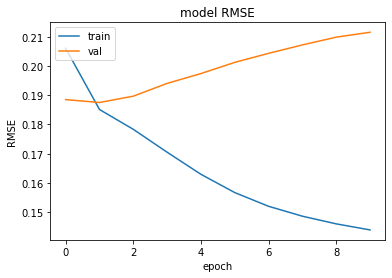

In [0]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Можем наблюдать, что при конкатенации векторов валидация с каждой эпохой ухудшается

## Усреднение эмбедингов

In [0]:
inputs = tf.keras.layers.Input(shape=(100,))


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs)
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [0]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
         epochs=10)

Epoch 1/10
249/249 [==============================] - 17s 68ms/step - loss: 0.2208 - root_mean_squared_error: 0.4700 - val_loss: 0.1915 - val_root_mean_squared_error: 0.4377
Epoch 2/10
249/249 [==============================] - 16s 66ms/step - loss: 0.1585 - root_mean_squared_error: 0.3983 - val_loss: 0.1251 - val_root_mean_squared_error: 0.3537
Epoch 3/10
249/249 [==============================] - 16s 65ms/step - loss: 0.1013 - root_mean_squared_error: 0.3184 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2856
Epoch 4/10
249/249 [==============================] - 16s 66ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 0.0649 - val_root_mean_squared_error: 0.2548
Epoch 5/10
249/249 [==============================] - 16s 66ms/step - loss: 0.0628 - root_mean_squared_error: 0.2507 - val_loss: 0.0593 - val_root_mean_squared_error: 0.2437
Epoch 6/10
249/249 [==============================] - 16s 65ms/step - loss: 0.0594 - root_mean_squared_error: 0.2439 - val_loss: 0

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


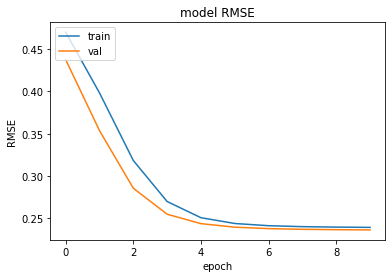

In [0]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

При усреднении эмбедингов мы наблюдаем, что с каждой эпохой качество постепенно растет на валидационной и тренировочной выборках (от 0.45 к 0.25)

## Сложение эмбедингов

In [0]:
inputs = tf.keras.layers.Input(shape=(100,))


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs)
emb_sum = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(emb_sum)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [0]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
         epochs=10)

Epoch 1/10
249/249 [==============================] - 16s 65ms/step - loss: 0.1014 - root_mean_squared_error: 0.3186 - val_loss: 0.0564 - val_root_mean_squared_error: 0.2376
Epoch 2/10
249/249 [==============================] - 16s 65ms/step - loss: 0.0571 - root_mean_squared_error: 0.2391 - val_loss: 0.0553 - val_root_mean_squared_error: 0.2352
Epoch 3/10
249/249 [==============================] - 16s 64ms/step - loss: 0.0561 - root_mean_squared_error: 0.2369 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2327
Epoch 4/10
249/249 [==============================] - 16s 64ms/step - loss: 0.0546 - root_mean_squared_error: 0.2336 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2279
Epoch 5/10
249/249 [==============================] - 16s 64ms/step - loss: 0.0513 - root_mean_squared_error: 0.2265 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2196
Epoch 6/10
249/249 [==============================] - 16s 63ms/step - loss: 0.0478 - root_mean_squared_error: 0.2185 - val_loss: 0

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


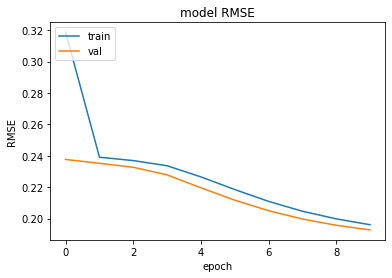

In [0]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

При сложении эмбедингов мы получили разброс меньше, чем при усреднении. Однако среднеквадратичная ошибка ближе к последним эпохам сопоставима с усреднением и даже опережает его (0.19 против 0.25)

## Использование 2 предобученных моделей

In [18]:
quora.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [0]:
ft = gensim.models.FastText([preprocess(text) for text in quora.question_text], size=100) 

In [0]:
w2v = gensim.models.Word2Vec([text for text in quora.question_text], size=100)

In [0]:
w2v_weights = np.zeros((len(w2v.wv.vocab) + 1, 100))
for i, vec in enumerate(w2v.wv.vectors):
  w2v_weights[i] = vec

In [0]:
ft_weights = np.zeros((len(ft.wv.vocab) + 1, 100))
for i, vec in enumerate(ft.wv.vectors):
  ft_weights[i] = vec

